# Forecasting Financial Securities Trading Volume with an LSTM Neural Network
<a name="toc"></a>

**Estimated time: 50 min**

This notebook will use the example of forecasting the trading volumes of financial securities, to demonstrate the set-up and implementation of a Long Short-Term Memory (LSTM) neural network for the purpose of prediction. 

In this lab, you will download a real dataset and format it for digestion by an LSTM. You will then set up the design of your LSTM network and train the model with the given data. You will use the trained LSTM model to predict the out-of-sample trading volumes, and evaluate the forecast's accuracy. A challenge at the end of this lab will provide you with an opportunity to think more critically about some of these areas.

**Table of Contents:** 

1. [Getting Started](#start)
1. [The Data](#data)
1. [Problem Statement](#problemstatement)
1. [Data Pre-processing](#engineering)
    1. [Reshape from a Time Series into Supervised Observations](#supervised)
    1. [Split into Training and Test Sets](#training)
    1. [Format the Data for LSTM Input](#reshape)
1. [Design the LSTM](#design)
    1. [Fit the LSTM Network with the Training Data](#fit)
1. [Predict the Test Data](#predict)
    1. [Evaluate the LSTM Performance](#evaluate)
1. [Lab Challenge](#challenge)
1. [Challege Solutions](#solution)

# Getting Started <a name="start"></a>

To complete this lab, carefully move through this notebook, from top to bottom, making sure to read all text instructions/explanations and run each code cell in order. Also be sure to view the code cell outputs. To run each cell, step-by-step in the Jupyter notebook, click within the cell and press **SHIFT + ENTER** or choose **Run** at the top of the page. You will know that a code cell has completed running when you see a number inside the square brackets located to the left of the code cell. Alternatively, **[ ]** indicates the cell has yet to be run, and **[*]** indicates that the cell is still processing.

Get started with this lab by learning a little more about the dataset you will be using throughout this notebook.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

# The Data <a name="data"></a>

Data for this lab is taken from the Deutsche Börse Public Dataset (PDS), a project that makes near-time data derived from Deutsche Börse's trading systems available to the public for free. By permission of Deutsche Börse, this dataset is made available under a Non-commercial (NC) license that allows licensees to copy, distribute, display, and perform the work and make derivative works and remixes based on it only for non-commercial purposes. 

For your next step, read the data from its S3 locations directly into your notebook's memory. The data may take a few seconds to output.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [21]:
import pandas as pd
csvList = ['s3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR13.csv',
           's3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR14.csv',
           's3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR15.csv']

raw = pd.concat([pd.read_csv(f, error_bad_lines=False, warn_bad_lines=False) for f in csvList], ignore_index = True)

dt = raw.iloc[0]['Date']
raw.drop(raw.index[raw['Date']!=dt], inplace=True)
raw['DateTime'] = pd.to_datetime(raw['Date'] + ' ' + raw['Time'])
raw.set_index('DateTime', inplace=True)
raw.head()

#trade_volume is Y that need to predict

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades
DateTime,,,,,,,,,,,,,,
2018-10-10 13:00:00,DE0006047004,HEI,HEIDELBERGCEMENT AG O.N.,Common stock,EUR,2505002,2018-10-10,13:00,63.580,63.620,63.580,63.620,340,4
2018-10-10 13:00:00,DE000SYM9999,SY1,SYMRISE AG INH. O.N.,Common stock,EUR,2504852,2018-10-10,13:00,72.400,72.460,72.400,72.460,617,9
2018-10-10 13:00:00,DE000A2LQ2L3,IGYB,INNOGY SE Z.VERK.,Common stock,EUR,3166236,2018-10-10,13:00,36.815,36.815,36.815,36.815,571,1
2018-10-10 13:00:00,LU1296758029,CCAP,CORESTATE CAPITAL HLDG,Common stock,EUR,2506149,2018-10-10,13:00,36.800,36.800,36.800,36.800,65,2
2018-10-10 13:00:00,DE0008232125,LHA,LUFTHANSA AG VNA O.N.,Common stock,EUR,2505130,2018-10-10,13:00,19.605,19.610,19.605,19.605,3002,4


## Problem Statement <a name="problemstatement"></a>

Within this dataset, you will focus on the univariate series, the column titled `TradedVolume`. This has the total size of trades made for a given security at its point in time. Take the trades in the 100 minutes from 13:30 PM to 15:10 PM, and see if you can use the first 70 minutes of trades to train a model, which can subsequently predict one-step ahead volumes for the subsequent 30 minutes.

Visualize this data by running the code below.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

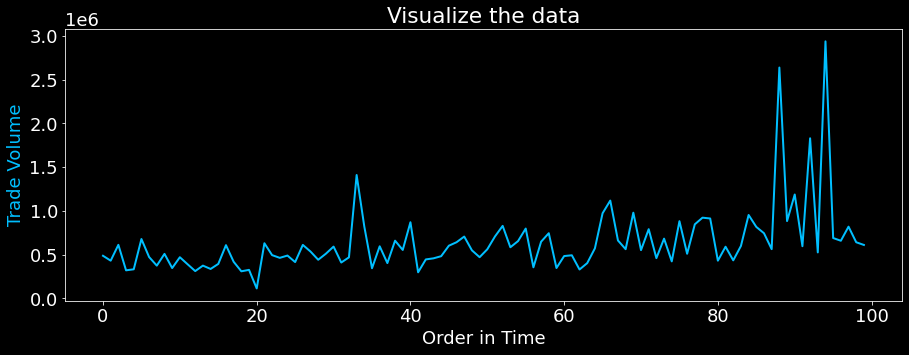

In [22]:
series = raw['TradedVolume'].resample('min').sum()['2018-10-10 13:30:00':'2018-10-10 15:09:00']

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = [15,5]

plt.figure(figsize=[15,5])
plt.plot(series.ravel(), color='deepskyblue')
plt.xlabel('Order in Time' );
plt.ylabel('Trade Volume', color='deepskyblue');
plt.title('Visualize the data');


## Data Pre-Processing <a name="engineering"></a>

With a time series, it is good practice to use the differences between the data points. This is because differenced data are more likely to recover stationarity. For example, if your data exhibits random walk behavior, its differences should oscillate around a constant mean of zero. So you'll do just this in the code cell below.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [23]:
raw_values = series.values
diff_series = series.diff().dropna()

### Reshape Data from a Time Series to Supervised Observations <a name="supervised"></a>

Remember, your goal is to predict the volume of the next traded security, that is, the volume at $t+1$.

Therefore, you need to reshape the data from being one long time series ${Y_t}$, into rows of supervised observations ${X_t, Y_t}$. You are using data at time $t-1$ as input to predict a value at time $t$. To do this, create a dataframe where each row has input column $t-1$ and output column $t$.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [24]:
def timeseries_to_supervised(data, look_back=1):
    df = pd.DataFrame(data).copy()
    columns = []
    for i in np.arange(look_back,-1,-1):
        df_i = df.shift(i).copy()
        df_i.columns = pd.Series(df_i.columns).map(lambda x: x+' (t-'+str(i)+')' if i>0 else x+' (t)' ).ravel()
        columns.append(df_i)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

look_back = 1
supervised = timeseries_to_supervised(diff_series, look_back)
supervised_values = supervised.values

supervised.head()

,TradedVolume (t-1),TradedVolume (t)
DateTime,,
2018-10-10 13:31:00,0.0,-55926.0
2018-10-10 13:32:00,-55926.0,181061.0
2018-10-10 13:33:00,181061.0,-291483.0
2018-10-10 13:34:00,-291483.0,11793.0
2018-10-10 13:35:00,11793.0,345996.0



### Split the Data Into Training and Test Sets <a name="training"></a>

How much data should you use for training the model, and how much should you leave for testing?

This is a trade-off:
 * The less data you use for training, the greater variance the parameter estimates will have. 
 * The less data you use for testing, the greater variance the performance statistic will have.
 
A rule of thumb is a 70%-to-30% split. 

**In the cell below, replace the entire placeholder text, starting with **#**, with *0.7* as the proportion of data to use for training:**

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [25]:
train_proportion = 0.7
#Enter proportion of data to use for training:0.7

In [26]:
n_obs, D = pd.DataFrame(series).shape
print('Number of observations (n_obs): ', n_obs)
print('Dimensionality/Numer of variates (D): ', D)

train_size = int(n_obs*train_proportion)
test_size = n_obs - train_size
train, test = supervised_values[0:-test_size], supervised_values[-test_size:]

Number of observations (n_obs):  100
Dimensionality/Numer of variates (D):  1


### Scale & Format the Data for LSTM Input <a name="reshape"></a>

For better performance, reduce the standard deviation of the data by scaling it to be within the range [-1,1].
 
<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

#### LSTM format

To format the data for LSTM input, first, separate the input from the output, $X$ from $Y$, in both the training and the test sets. Then, reshape the $X$ input to be $\big($ `#Samples`, `#Timesteps` or the look_back, `#Features` $\big)$ to be digestible for LSTM in-take.

In [28]:
trainX, trainy = train_scaled[:, 0:-D], train_scaled[:, -D:]
testX, testy = test_scaled[:, 0:-D], test_scaled[:, -D:]

trainX3d = trainX.reshape(trainX.shape[0], look_back, trainX.shape[1])
testX3d = testX.reshape(testX.shape[0], look_back, testX.shape[1])

#reshape into 3 dimention array, LSTM input is always 3D:(batch_size, time_steps,features).
print('Matrix shape:', trainX.shape) #(batch_size, time_steps)
print('LSTM shape:', trainX3d.shape)
#LSTM shape: (樣本數69，時間步長1，input dimention=features 1)

Matrix shape: (69, 1)
LSTM shape: (69, 1, 1)


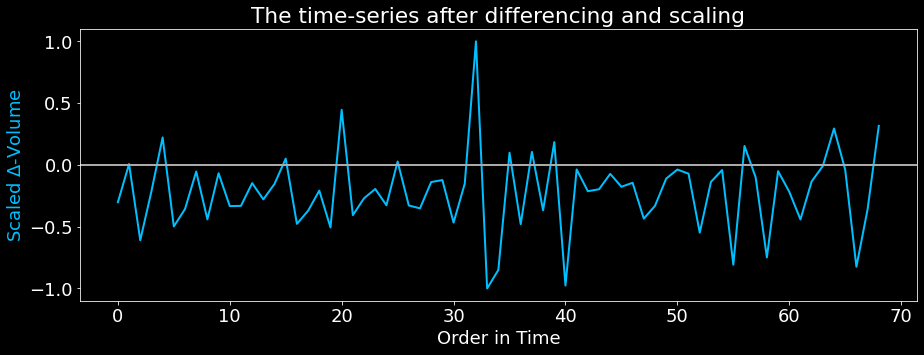

In [29]:
plt.style.use(['dark_background'])
plt.figure(figsize=[15,5])
plt.plot(trainy, color='deepskyblue');
plt.axhline(y=0, color='darkgray')
plt.xlabel('Order in Time' );
plt.ylabel('Scaled $\Delta$-Volume', color='deepskyblue');
plt.title('The time-series after differencing and scaling');



## Design the LSTM <a name="design"></a>

You will use the [Keras](https://keras.io/) [Chollet, 2015.] library to design your neural network (NN). 

* The `Sequential()` model allows you to organize the layers of your NN.
* Add another linear layer using `.add()`. 
    * Add an `LSTM()` layer where you specify hyperparameters such as the number or `neurons` or units to have in the hidden layer, or the `batch size` with which to update the model, the $\tanh$ `activation` function, etc.
* Add a final `Dense()` layer to ensure the neural output matches the dimensionality of your $Y$.
* With `.compile()`, specify which `loss function` to use. You want to minimize the Mean Squared Error (MSE), and in particular, minimize it by using a type of Stochastic Gradient Descent variant known as [Adam](https://arxiv.org/abs/1412.6980) [Kingma, 2015].

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [30]:
import keras

neurons = 4
batch_size = 1 

import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras import layers

model = models.Sequential()
#neurons=input,  batch_input_shape=( number of time steps / number of input units is 2
#neurons=input,  batch_input_shape=( time steps 1 /input units is 2)
model.add(layers.LSTM(neurons, batch_input_shape=(batch_size, trainX3d.shape[1], trainX3d.shape[2]), activation='tanh', stateful=True, name='Hidden'))
model.add(layers.Dense(1, name='Final'))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden (LSTM)                (1, 4)                    96        
_________________________________________________________________
Final (Dense)                (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
import keras

In [32]:
!pip list | grep -i keras

Keras                              2.2.4
Keras-Applications                 1.0.8
Keras-Preprocessing                1.1.2


In [33]:
trainX3d.shape[2]


1

In [34]:
trainX3d.shape[1]

1

## Fit an LSTM Network to Training Data <a name="fit"></a>

Now you are ready to train your NN model. Use `verbose=1` to track the behavior of the training and validation losses.

An epoch is one complete pass through the training data into the algorithm. Use 30 passes of our training data.

**In the cell below, replace the entire placeholder text, starting with **#**, with *30* as the number of epochs to use for fitting:**

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [35]:
nb_epoch = 30
#Enter the number of epochs:30

In [36]:
lstm_model = model.fit(trainX3d, trainy, validation_split=0.2, epochs=nb_epoch, batch_size=batch_size, verbose=1)
#lstm_model(seq_len=100, batch_size=128, stateful=False, max_tokens = MAX_TOKENS)


Train on 55 samples, validate on 14 samples
Epoch 1/30
55/55 [==============================] - 2s 40ms/step - loss: 0.1245 - val_loss: 0.1521
Epoch 2/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.1485
Epoch 3/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1137 - val_loss: 0.1467
Epoch 4/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1061 - val_loss: 0.1416
Epoch 5/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1099 - val_loss: 0.1445
Epoch 6/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1053 - val_loss: 0.1407
Epoch 7/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1072 - val_loss: 0.1393
Epoch 8/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1032 - val_loss: 0.1382
Epoch 9/30
55/55 [==============================] - 0s 3ms/step - loss: 0.1058 - val_loss: 0.1375
Epoch 10/30
55/55 [==============================] - 0s 3ms/step - loss: 

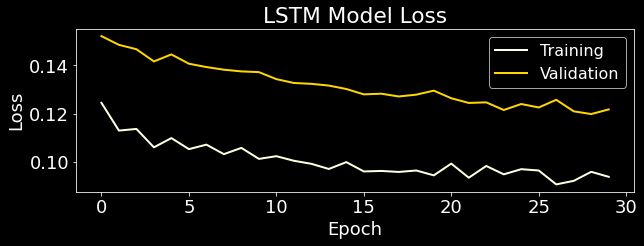

In [37]:
plt.figure(figsize=[10,3])
plt.plot(lstm_model.history['loss'], label='Training', color='lightyellow')
plt.plot(lstm_model.history['val_loss'], label='Validation', color='gold')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
l = plt.legend(fontsize=16)
plt.show()

## Predict the Test Data <a name="predict"></a>

Use your trained LSTM neural network to predict trading volumes one-step-ahead, for the remaining series:
* Forecast the entire training dataset to build up state for forecasting
* Forecast the entire test dataset
* Invert the scaling 
* Revert the differencing 

Then you've arrived at your predictions in their proper units.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [19]:
 from numpy import matlib as mb

In [38]:
model.predict(trainX3d, batch_size=batch_size)
predictions_scaled = model.predict(testX3d, batch_size=1)

predictions_unscaled = scaler.inverse_transform(np.matlib.repmat(predictions_scaled, 1, train.shape[1]))[:,-1]
predictions = raw_values[train_size:] + predictions_unscaled

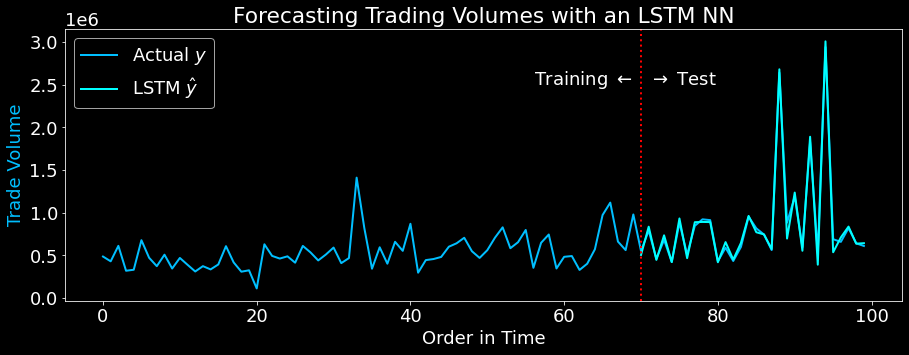

In [39]:
plt.figure(figsize=[15,5])
plt.style.use(['dark_background'])
plt.plot(raw_values, label=r'Actual $y$', color='deepskyblue')
plt.plot(np.arange(train_size, n_obs), predictions, label=r'LSTM $\hat{y}$', color='aqua')
plt.axvline(x=train_size, color='red', linestyle=':')
plt.text(train_size-1, 2500000, r'Training $\leftarrow$', horizontalalignment='right')
plt.text(train_size+1, 2500000, r'$\rightarrow$ Test', horizontalalignment='left')
plt.xlabel('Order in Time');
plt.ylabel('Trade Volume', color='deepskyblue');
plt.title('Forecasting Trading Volumes with an LSTM NN');
plt.legend()
plt.show()

## Evaluate the LSTM Performance <a name="evaluate"></a>

The Root-Mean-Squared Error (RMSE) allows you to compare how accurate your forecasts were to the actual traded volumes. The lower the RMSE, the better - a value of 0 would indicate a perfect fit to the data. 

[//]: $$ \rm{RMSE} = \sqrt {\frac {\sum _{t=1}^T(\hat{y}_t-y_t)^2}{T}} $$

RMSE is dependent on the scale of the data being used. Dividing the RMSE by the range of the data, gives an average error as a proportion of the data's scale. This is called the **Normalized Root-Mean-Squared Error** (NRMSE).

[//]: $$ \mathrm{NRMSE} = \frac{\mathrm{RMSE}}{y_\max -y_\min} $$

However, the RMSE and NRMSE are very sensitive to outliers. A robust version is the **Normalized Median Absolute Deviation** (NMAD).

[//]: $$ \mathrm{NMAD} = \frac{\rm{median}|\hat{y}_t-y_t|}{y_\max -y_\min} $$

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [40]:
from sklearn.metrics import mean_squared_error, median_absolute_error

rmse = np.sqrt(mean_squared_error(raw_values[-test_size:], predictions))
mad = median_absolute_error(raw_values[-test_size:], predictions)
ymax = raw_values[-test_size:].max()
ymin = raw_values[-test_size:].min()
nrmse = rmse/(ymax - ymin)*100
nmad = mad/(ymax - ymin)*100

print('Normalized Root-Mean-Squared Error: %2.1f%%' %nrmse)
print('Normalized Median Absolute Deviation: %2.1f%%' %nmad)

Normalized Root-Mean-Squared Error: 2.5%
Normalized Median Absolute Deviation: 1.7%


___

# BREAK

Please pause here for a few minutes so we can come back together as a group to review important aspects of what you just accomplished in the above portion of this lab. The instructor will take approximately 5 minutes to review a few of these important aspects prior to you moving on to the challenge below. 
___


## Lab 1 Challenge: Multivariate <a name="challenge"></a>

This section of the notebook is the lab challenge, wherein you'll get a chance to think more critically about the code that's being written. It builds on the material and code you just went through above. You use the same data source, the [Deutsche Börse Public Dataset](https://registry.opendata.aws/deutsche-boerse-pds/), but look specifically at the company DAIMLER (DAI) AG, the German automotive corporation of which Mercedes Benz is a subsidiary. 

Take the stock price of DAI at the start of the minute and the volume traded by the end of the minute, for the minutes between 1pm and 3pm on October 10, 2018. This problem becomes the prediction of two related time series - a multivariated forecasting problem. In this challenge, the plotting and light coding is handled for you, but where prompted `# To complete as challenge`, fill in the missing section with the code necessary to complete the LSTM solution.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [21]:
# Clear all environment variables from Lab 1 above
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [22]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
csvList = ['s3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR13.csv',
           's3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR14.csv',
           's3://deutsche-boerse-xetra-pds/2018-10-10/2018-10-10_BINS_XETR15.csv']

raw = pd.concat([pd.read_csv(f, error_bad_lines=False, warn_bad_lines=False) for f in csvList], ignore_index = True)

dt = raw.iloc[0]['Date']
raw.drop(raw.index[raw['Date']!=dt], inplace=True)
raw['DateTime'] = pd.to_datetime(raw['Date'] + ' ' + raw['Time'])
raw.set_index('DateTime', inplace=True)

df = raw.loc[raw['Mnemonic']=='DAI'].loc['2018-10-10 13:00:00':'2018-10-10 15:00:00'].resample('min').mean()
df.head(3)

,SecurityID,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades
DateTime,,,,,,,
2018-10-10 13:00:00,2505076,54.17,54.20,54.17,54.19,3671,16
2018-10-10 13:01:00,2505076,54.19,54.19,54.16,54.17,1860,11
2018-10-10 13:02:00,2505076,54.17,54.17,54.14,54.16,3944,20


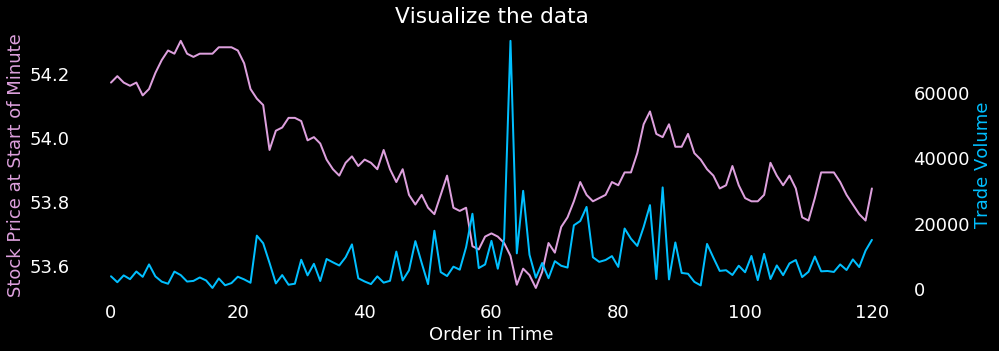

In [54]:
series = df[['StartPrice','TradedVolume']]
series['StartPrice'].fillna(method='ffill', inplace=True)
series['TradedVolume'].fillna(0, inplace=True)

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = [15,5]

plt.figure(figsize=[15,5])
plt.plot(series['StartPrice'].ravel(), label='StartPrice', color='plum')
plt.ylabel('Stock Price at Start of Minute', color='plum' );
plt.xlabel('Order in Time' );

ax = plt.twinx()
plt.plot(series['TradedVolume'].ravel(), label='TradedVolume', color='deepskyblue')
plt.ylabel('Trade Volume', color='deepskyblue');
plt.title('Visualize the data');

## Data Pre-Processing 

* Now, take the consecutive differences of the data. 
* You need to use the `timeseries_to_supervised` function from this lab to reshape the data from a time series to supervised observations. 


In [24]:
# Take the consecutive differences of the data
raw_values = series.values
diff_series = series.diff().fillna(0)


# Use the timeseries_to_supervised function from Lab 1 to reshape data from a time series to supervised observations 
def timeseries_to_supervised(data, look_back=1):
    df = pd.DataFrame(data).copy()
    columns = []
    for i in np.arange(look_back,-1,-1):
        df_i = df.shift(i).copy()
        df_i.columns = pd.Series(df_i.columns).map(lambda x: x+' (t-'+str(i)+')' if i>0 else x+' (t)' ).ravel()
        columns.append(df_i)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


#assert timeseries_to_supervised(diff_series)!='<To complete as challenge>', 'Challenge not completed'

look_back = 1
#supervised = '<To complete as challenge>' # To complete as challenge
supervised = timeseries_to_supervised(diff_series, look_back)
#assert supervised!='<To complete as challenge>', 'Challenge not completed'

supervised_values = supervised.values
supervised.head()



,StartPrice (t-1),TradedVolume (t-1),StartPrice (t),TradedVolume (t)
DateTime,,,,
2018-10-10 13:00:00,0.00,0.0,0.00,0.0
2018-10-10 13:01:00,0.00,0.0,0.02,-1811.0
2018-10-10 13:02:00,0.02,-1811.0,-0.02,2084.0
2018-10-10 13:03:00,-0.02,2084.0,-0.01,-1154.0
2018-10-10 13:04:00,-0.01,-1154.0,0.01,2347.0


Split the data into training and test sets.

In [25]:
train_proportion = 0.7 
n_obs = len(supervised_values)
train_size = int(n_obs*train_proportion)
test_size = n_obs - train_size
train, test = supervised_values[0:-test_size], supervised_values[-test_size:]

print('Training set:', train.shape)
print('Test set:', test.shape)

Training set: (84, 4)
Test set: (37, 4)


## Scale & Format the Data for LSTM Input

* The `MinMaxScaler` is defined for you.

You need to:
* Fit the scaler to the training set.
* Use the fitted scaler to transorm the training set.
* Use the fitted scaler to transorm the test set.

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = # To complete as challenge
scaler = scaler.fit(train)

#train_scaled = # To complete as challenge
train_scaled = scaler.transform(train)

#test_scaled = # To complete as challenge
test_scaled = scaler.transform(test)

* Define D as the dimensionality of your multivariate output.
* Separate the input from the output, $X$ from $Y$, in both the training and the test sets.
* Reshape the $X$ input to be (#Samples, #Timesteps or the look_back, #Features) and digestible for LSTM in-take.

In [34]:
D = series.shape[1] #多變量分析

trainX, trainy = train_scaled[:, 0:-D], train_scaled[:, -D:]
testX, testy = test_scaled[:, 0:-D], test_scaled[:, -D:]

#trainX3d = # To complete as challenge
trainX3d = trainX.reshape(trainX.shape[0], look_back, trainX.shape[1])
#testX3d = # To complete as challenge
testX3d = testX.reshape(testX.shape[0], look_back, testX.shape[1])

#reshape into 3 dimention array, LSTM input is always 3D:(batch_size, time_steps,seq_len).
print('Matrix shape:', trainX.shape) #batch_size, features
print('LSTM shape:', trainX3d.shape)
#LSTM shape: (樣本數84，時間步長1，input dimention=features 2)

Matrix shape: (84, 2)
LSTM shape: (84, 1, 2)


In [49]:
print('Matrix shape:', testX.shape)
print('LSTM shape:', testX3d.shape)
#LSTM shape: (樣本數69，時間步長1，input dimention 2)

Matrix shape: (37, 2)
LSTM shape: (37, 1, 2)


In [52]:
print(trainX.shape[0])

84


In [53]:
D

2

Plot the scaled, differenced time series.

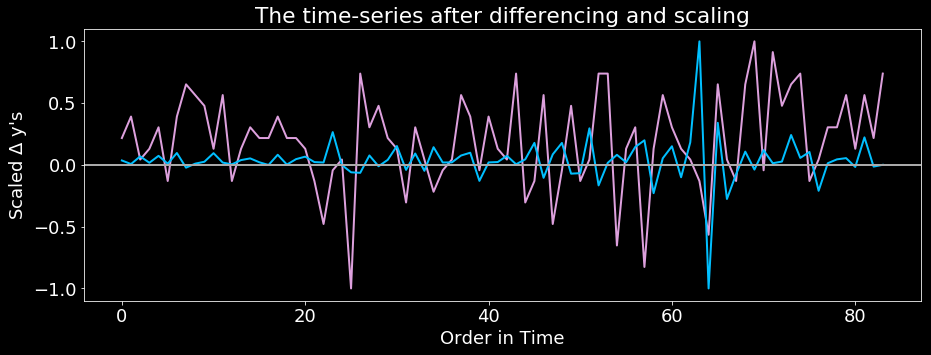

In [35]:
plt.style.use(['dark_background'])
plt.figure(figsize=[15,5])
plt.plot(trainy[:,0], label='StartPrice', color='plum');
plt.plot(trainy[:,1], label='TradedVolume', color='deepskyblue');

plt.axhline(y=0, color='darkgray')
plt.xlabel('Order in Time' );
plt.ylabel('Scaled $\Delta$ y\'s' );
plt.title('The time-series after differencing and scaling');

## Design the LSTM 

* Instantiate the keras model with `Sequential()` to allow you to organize the layers of your neural network.
* You need to specify your `LSTM` layer and add it to the model.
 * You need to specify the number of `neurons`. 
  * It's recommended to use a value greater than 3 and less than 10 for this specific challenge to achieve a good trade-off between model accuracy and training time.
 * You need to specify the `batch_size`. (1 is recommended for this data size.) 
 * You should specify the `activation` function.
 * You can specify a string `name` for this layer, such as 'Hidden LSTM 1'.
* You can add more than one LSTM layer, if you're feeling ambitious for this challenge.
* You need to specify the final `Dense()` layer with output to have the same dimensionality of our $Y$.
* You need to specify the `.compile()` call of the model with the loss function to use. 
 * It is recommended to use the `mean_squared_error` loss, and the `adam` variant of Stochastic Gradient Descent optimization.

In [36]:
from keras import models
from keras import layers

model = models.Sequential()

neurons = 4
batch_size = 1 
#model.add( # To complete as challenge ) 
#layer.LSTM(units, batch_input_shape=(batch_size, time_steps, seq_len).)
model.add(layers.LSTM(neurons, batch_input_shape=(batch_size, trainX3d.shape[1], trainX3d.shape[2]), activation='tanh', stateful=True, name='Hidden'))


#model.add( # To complete as challenge )
model.add(layers.Dense(D, name='Final'))

#model.compile( # To complete as challenge )
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

#2D summary: output shape(batch_size, neurons)
#3D summary: output shape(batch_size, number of time steps, neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden (LSTM)                (1, 4)                    112       
_________________________________________________________________
Final (Dense)                (1, 2)                    10        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
None


## Fit an LSTM Network to Training Data 
* Specify 30 epochs and a 20% validation hold-out.
* Plot the training loss and the validation loss at each epoch of fitting the neural network.

In [37]:
nb_epoch = 30
lstm_model = model.fit(trainX3d, trainy, validation_split=0.2, epochs=nb_epoch, batch_size=batch_size, verbose=1)


Train on 67 samples, validate on 17 samples
Epoch 1/30
67/67 [==============================] - 1s 22ms/step - loss: 0.0998 - val_loss: 0.1362
Epoch 2/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0927 - val_loss: 0.1266
Epoch 3/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0938 - val_loss: 0.1221
Epoch 4/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.1153
Epoch 5/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0928 - val_loss: 0.1135
Epoch 6/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0886 - val_loss: 0.1112
Epoch 7/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0888 - val_loss: 0.1082
Epoch 8/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.1090
Epoch 9/30
67/67 [==============================] - 0s 2ms/step - loss: 0.0889 - val_loss: 0.1065
Epoch 10/30
67/67 [==============================] - 0s 2ms/step - loss: 

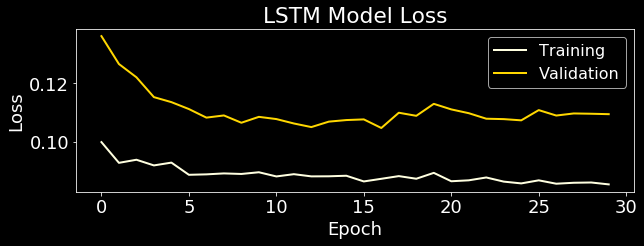

In [38]:
plt.figure(figsize=[10,3])
plt.plot(lstm_model.history['loss'], label='Training', color='lightyellow')
plt.plot(lstm_model.history['val_loss'], label='Validation', color='gold')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
l = plt.legend(fontsize=16)
plt.show()

## Predict the Test Data 

Use your trained LSTM neural network to predict the next minute's Starting Stock Price and its Trading Volume.
* Handle the inversion of the scaling and the reversal of the differencing as well.
* Plot the results of your LSTM below.

In [39]:
model.predict(trainX3d, batch_size=batch_size)
predictions_scaled = model.predict(testX3d, batch_size=1)

predictions_unscaled = scaler.inverse_transform(np.matlib.repmat(predictions_scaled, 1, int(train.shape[1]/D)) )[:,-D:]
predictions = raw_values[train_size:-1] + predictions_unscaled[:-1]

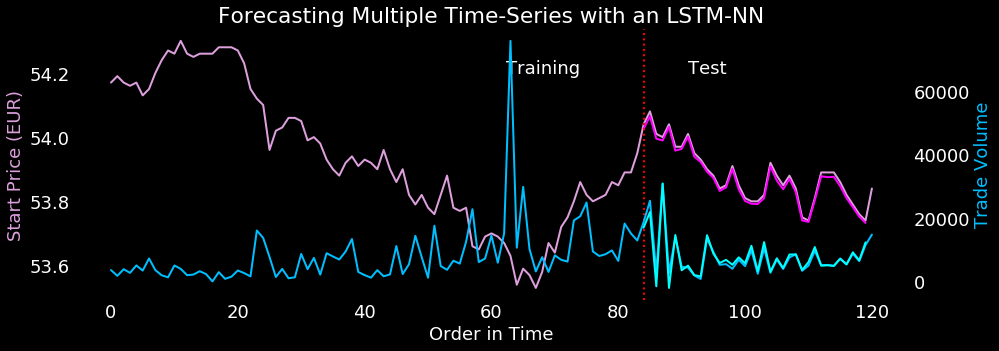

In [40]:
import seaborn as sns
plt.figure(figsize=[15,5])
sns.set_style("dark")
plt.style.use(['dark_background'])
plt.plot(raw_values[:,0], label=r'Actual $y$', color='plum')
plt.plot(np.arange(train_size, n_obs-1), predictions[:,0], label=r'LSTM $\hat{y}$', color='magenta')
plt.axvline(x=train_size, color='red', linestyle=':')
plt.text(train_size-10, 54.2, r'Training', horizontalalignment='right')
plt.text(train_size+7, 54.2, r'Test', horizontalalignment='left')
plt.xlabel('Order in Time' );
plt.ylabel('Start Price (EUR)', color='plum');

ax = plt.twinx()
plt.plot(raw_values[:,1], label=r'Actual $y$', color='deepskyblue')
plt.plot(np.arange(train_size, n_obs-1), predictions[:,1], label=r'LSTM $\hat{y}$', color='aqua')
plt.ylabel('Trade Volume', color='deepskyblue');
plt.title('Forecasting Multiple Time-Series with an LSTM-NN');
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error, median_absolute_error

for d in range(D):
    rmse = np.sqrt(mean_squared_error(raw_values[-test_size+1:,d], predictions[:,d]))
    mad = median_absolute_error(raw_values[-test_size+1:,d], predictions[:,d])
    ymax = raw_values[-test_size+1:,d].max()
    ymin = raw_values[-test_size+1:,d].min()
    nrmse = rmse/(ymax - ymin)*100
    nmad = mad/(ymax - ymin)*100

    print('Dimension %i, Normalized Root-Mean-Squared Error: %2.1f%%' %(d, nrmse))
    print('Dimension %i, Normalized Median Absolute Deviation: %2.1f%%' %(d, nmad))
    print('')

Dimension 0, Normalized Root-Mean-Squared Error: 13.6%
Dimension 0, Normalized Median Absolute Deviation: 8.2%

Dimension 1, Normalized Root-Mean-Squared Error: 31.6%
Dimension 1, Normalized Median Absolute Deviation: 11.6%



In [42]:
!python --version

Python 3.6.5 :: Anaconda custom (64-bit)


## Lab Complete

Congratulations! You have completed this lab. If you want to review the Solutions to the Lab Challenges see the next section of this notebook before ending this lab. 

<div style=\"text-align: right\"><b>END OF LAB</b></div>

## Solutions to Lab Challenges <a name="solution"></a>

Below are the solutions to each of the challenges you encountered above. They are identified by the corresponding section titles. 

### Data Pre-Processing 
* **Solution:**  
```python
def timeseries_to_supervised(data, look_back=1):
    df = pd.DataFrame(data).copy()
    columns = []
    for i in np.arange(look_back,-1,-1):
        df_i = df.shift(i).copy()
        df_i.columns = pd.Series(df_i.columns).map(lambda x: x+' (t-'+str(i)+')' if i>0 else x+' (t)' ).ravel()
        columns.append(df_i)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
```
* **Solution:** 
```python
supervised = timeseries_to_supervised(diff_series, look_back)
```

### Scale and Format the Data for LSTM Input 
* **Solution:** 
```python
scaler = scaler.fit(train)
```
* **Solution:** 
```python
train_scaled = scaler.transform(train)
```
* **Solution:** 
```python
test_scaled = scaler.transform(test)
``` 
* **Solution:** 
```python
trainX3d = trainX.reshape(trainX.shape[0], look_back, trainX.shape[1])
``` 
* **Solution:** 
```python
testX.reshape(testX.shape[0], look_back, testX.shape[1])
``` 

### Design the LSTM 
* **Solution:** 
```python
model.add(layers.LSTM(neurons, batch_input_shape=(batch_size, trainX3d.shape[1], trainX3d.shape[2]), activation='tanh', stateful=True, name='Hidden'))
```
* **Solution:** 
```python
model.add(layers.Dense(D, name='Final'))
``` 
* **Solution:** 
```python
model.compile(loss='mean_squared_error', optimizer='adam')
```

<div style="text-align: right"><a href="#toc">Back to top</a></div>